In [26]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import spacy

In [27]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nehal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nehal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
# Initialize tools for preprocessing
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')

In [29]:
# Load dataset
data = pd.read_csv(r"C:\Users\nehal\Documents\GitHub\msba265-finalstorage\data_storage\Text\Twitter-Facebook.csv", encoding='latin1')

In [30]:
# Display the first few rows
print(data.head())

   No.                                            Message   Source  Label   
0    1  i feel awful about it too because it s my job ...  Twitter      0  \
1    2                              im alone i feel awful  Twitter      0   
2    3  ive probably mentioned this before but i reall...  Twitter      1   
3    4           i was feeling a little low few days back  Twitter      0   
4    5  i beleive that i am much more sensitive to oth...  Twitter      2   

   Emotion  
0  sadness  
1  sadness  
2      joy  
3  sadness  
4     love  


In [31]:
# Data Cleaning
data_cleaned = data.dropna()  # Remove missing values
data_cleaned = data_cleaned.drop_duplicates(subset=['Message'])  # Remove duplicate messages
data_cleaned.columns = data_cleaned.columns.str.strip().str.lower().str.replace(" ", "_")  # Standardize column names

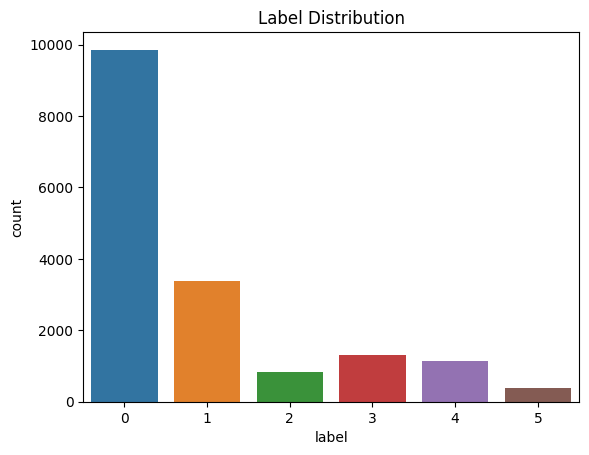

In [32]:
# EDA: Distribution of Labels
sns.countplot(data=data_cleaned, x='label')
plt.title("Label Distribution")
plt.show()

In [33]:
# Add message length as a feature
data_cleaned['message_length'] = data_cleaned['message'].apply(len)

C:\Users\nehal\anaconda3\Anacondaupdate\envs\fresh_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


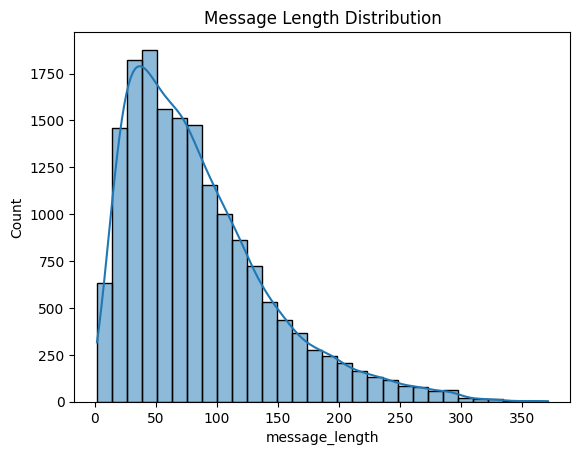

In [34]:
# Plot message length distribution
sns.histplot(data=data_cleaned, x='message_length', bins=30, kde=True)
plt.title("Message Length Distribution")
plt.show()

In [35]:
# Encode the target column
encoder = LabelEncoder()
data_cleaned['label_encoded'] = encoder.fit_transform(data_cleaned['label'])

In [36]:
# Prepare the target variable
y = data_cleaned['label_encoded']

In [37]:
# Feature Engineering
data_cleaned['num_exclamation'] = data_cleaned['message'].str.count('!')
data_cleaned['num_mentions'] = data_cleaned['message'].str.count('@')
data_cleaned['num_hashtags'] = data_cleaned['message'].str.count('#')
additional_features = data_cleaned[['message_length', 'num_exclamation', 'num_mentions', 'num_hashtags']].values

In [38]:
# Preprocessing function with stemming and lemmatization
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    # Stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    # Lemmatization
    doc = nlp(" ".join(tokens))
    lemmatized_tokens = [token.lemma_ for token in doc]
    return " ".join(lemmatized_tokens) 

In [ ]:
# Text Preprocessing with Lemmatization
#def preprocess_text(text):
    # Lowercase text = text.lower()
    # Tokenize tokens = word_tokenize(text)
    # Remove stopwords tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    # Lemmatization doc = nlp(" ".join(tokens)) lemmatized_tokens = [token.lemma_ for token in doc] return " ".join(lemmatized_tokens)

In [39]:
# Apply preprocessing
data['Processed'] = data['Message'].apply(preprocess_text)

In [40]:
# Text vectorization using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_features=2000)
X_vectorized = vectorizer.fit_transform(data['Processed']).toarray()

In [41]:
# Example of additional features
data['message_length'] = data['Message'].apply(len)
data['num_exclamation'] = data['Message'].apply(lambda x: x.count('!'))
data['num_mentions'] = data['Message'].apply(lambda x: x.count('@'))
data['num_hashtags'] = data['Message'].apply(lambda x: x.count('#'))
additional_features = data[['message_length', 'num_exclamation', 'num_mentions', 'num_hashtags']].values

In [42]:
# Combine TF-IDF features with additional features
X_combined = np.hstack([X_vectorized, additional_features])
y = data['Label']

In [47]:
# Check original class distribution
print("Original class distribution:", Counter(y))

Original class distribution: Counter({0: 9942, 1: 3372, 3: 1299, 4: 1146, 2: 833, 5: 390})


In [48]:
# Apply SMOTE with specific sampling strategy
smote = SMOTE(sampling_strategy={ 
    1: 4000,  # Upsample class 1 to 4000
    2: 5000,  # Upsample class 2 to 5000
    3: 5000,  # Upsample class 3 to 5000
    4: 4000,  # Upsample class 4 to 4000
    5: 5000 
}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_combined, y)

In [49]:
# Scale features after SMOTE
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

In [50]:
# Check new class distribution
print("Class distribution after SMOTE:", Counter(y_resampled))

Class distribution after SMOTE: Counter({0: 9942, 2: 5000, 3: 5000, 5: 5000, 1: 4000, 4: 4000})


In [51]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled_scaled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

In [ ]:
# Hyperparameter Tuning for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}
rf_model = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='accuracy', verbose=1)
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [ ]:
# Get the best Random Forest model
best_rf_model = grid_search_rf.best_estimator_

In [ ]:
# Evaluate the best Random Forest model
y_pred_rf = best_rf_model.predict(X_test)
print(f"Best Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print("\nBest Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

In [ ]:
# Hyperparameter Tuning for Logistic Regression
from sklearn.model_selection import GridSearchCV
log_reg = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}  # Regularization parameter
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

In [ ]:
# Get the best model
best_model = grid_search.best_estimator_

In [ ]:
# Evaluate the best model on the test set
y_pred_best = best_model.predict(X_test)
print(f"Best Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_best):.2f}")
print("\nBest Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_best))

In [20]:
# Define the basic_info function
def basic_info(data):
    print("Basic Information of the Dataset:")
    print(data.info())  # Prints info about the dataset
    print("\nFirst few rows of the dataset:")
    print(data.head())

In [21]:
# Define the summary_statistics function
def summary_statistics(data):
    print("\nSummary Statistics:")
    print(data.describe())  # Summary statistics like mean, min, max, etc.


In [15]:
# Univariate Analysis
def univariate_analysis(data):
    print("\n### Univariate Analysis ###")
    print("Value Counts for Source:")
    print(data['Source'].value_counts())
    print("\nValue Counts for Emotion:")
    print(data['Emotion'].value_counts())

In [22]:
# Define the bivariate_analysis function
def bivariate_analysis(data):
    print("\nBivariate Analysis:")
    # Example: Scatter plot between two columns (replace with actual columns)
    plt.figure(figsize=(8,6))
    sns.scatterplot(x='Column1', y='Column2', data=data)
    plt.title("Bivariate Analysis: Column1 vs Column2")
    plt.show()

In [24]:
# Define the text_analysis function
def text_analysis(data):
    print("\nText Analysis:")
    # Example: Word count for a text column
    data['word_count'] = data['Message'].apply(lambda x: len(str(x).split()))
    print(data[['Message', 'word_count']].head())

In [25]:
# Define the advanced_text_analysis function 
def advanced_text_analysis(data):
    print("\nAdvanced Text Analysis:")
    stop_words = set(stopwords.words('english'))
    data['cleaned_message'] = data['Message'].apply(lambda x: ' '.join([word for word in word_tokenize(str(x).lower()) if word.isalpha() and word not in stop_words]))

In [27]:
# Define the correlation_analysis function
def correlation_analysis(data):
    print("\nCorrelation Analysis:")
    # Example: Correlation between numerical features
    correlation_matrix = data.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Matrix")
    plt.show()